In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('/kaggle/input/fundus-dataset/dataset.csv')

In [3]:
df

,image_path,class,label_encoded
0,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
1,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
2,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
3,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
4,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
...,...,...,...
4507,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4508,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4509,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4510,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5


In [4]:
# Görüntüleri yükleme ve ön işleme fonksiyonu
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = Image.open(image_path).resize(target_size)  # Görüntüyü yeniden boyutlandır
    image = np.array(image) / 255.0  # Normalizasyon (0-1 aralığına getir)
    return image

In [5]:
# One-hot encoding işlemi
y = to_categorical(df['label_encoded'])

# Görüntüleri ve etiketleri yükleme
X = np.array([load_and_preprocess_image(path) for path in df['image_path']])


In [6]:
# Veriyi eğitim, doğrulama ve test setlerine ayırma
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # %70 eğitim, %30 geçici
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # %15 doğrulama, %15 test

print("Eğitim verisi şekli:", X_train.shape)
print("Doğrulama verisi şekli:", X_val.shape)
print("Test verisi şekli:", X_test.shape)

Eğitim verisi şekli: (3158, 224, 224, 3)
Doğrulama verisi şekli: (677, 224, 224, 3)
Test verisi şekli: (677, 224, 224, 3)


In [9]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.losses import CategoricalFocalCrossentropy

for layer in base_model.layers[-15:]:
    layer.trainable = True

# Cyclical Learning Rate fonksiyonu
def cyclical_learning_rate(epoch, initial_lr=1e-6, max_lr=5e-5, step_size=1000, scale_fn=lambda x: 1 / (2.0 ** (x - 1))):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = initial_lr + (max_lr - initial_lr) * np.maximum(0, (1 - x)) * scale_fn(cycle)
    return lr

# Learning Rate Scheduler tanımla
lr_scheduler = LearningRateScheduler(cyclical_learning_rate)


# Early stopping callback'i tanımla
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Öğrenme oranını dinamik olarak azalt
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)


model.compile(
    optimizer=AdamW(learning_rate=5e-5, weight_decay=1e-3),
    loss=CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, label_smoothing=0.1),
    metrics=['accuracy']
)
# Model eğitimi
# Modeli eğitme
history = model.fit(
    X_train, y_train,                # Eğitim verisi
    batch_size=32,                   # Batch size
    epochs=100,                      # Epoch sayısı
    validation_data=(X_val, y_val),  # Doğrulama verisi
)

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 113s 509ms/step - accuracy: 0.2311 - loss: 1.1093 - val_accuracy: 0.1123 - val_loss: 1.0051
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.2842 - loss: 1.0503 - val_accuracy: 0.1300 - val_loss: 1.0008
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.3057 - loss: 1.0137 - val_accuracy: 0.1285 - val_loss: 1.1149
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.3593 - loss: 0.9863 - val_accuracy: 0.1300 - val_loss: 1.0997
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.4005 - loss: 0.9420 - val_accuracy: 0.1359 - val_loss: 1.0745
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.3817 - loss: 0.9436 - val_accuracy: 0.1713 - val_loss: 1.0131
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.4110 - loss: 0.9279 - val_accuracy: 0.3043 - val_loss: 0.9167
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.4478 - loss: 0.9019 -

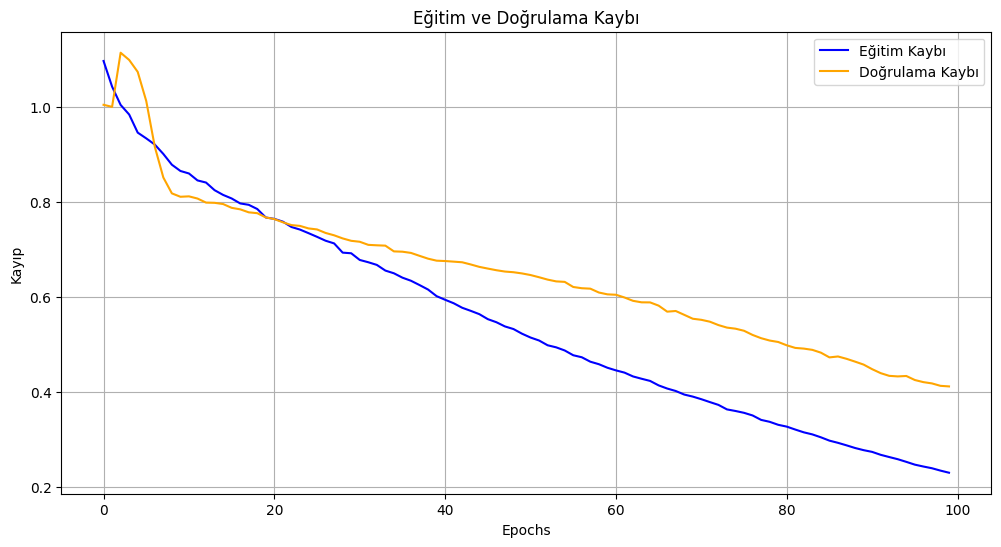

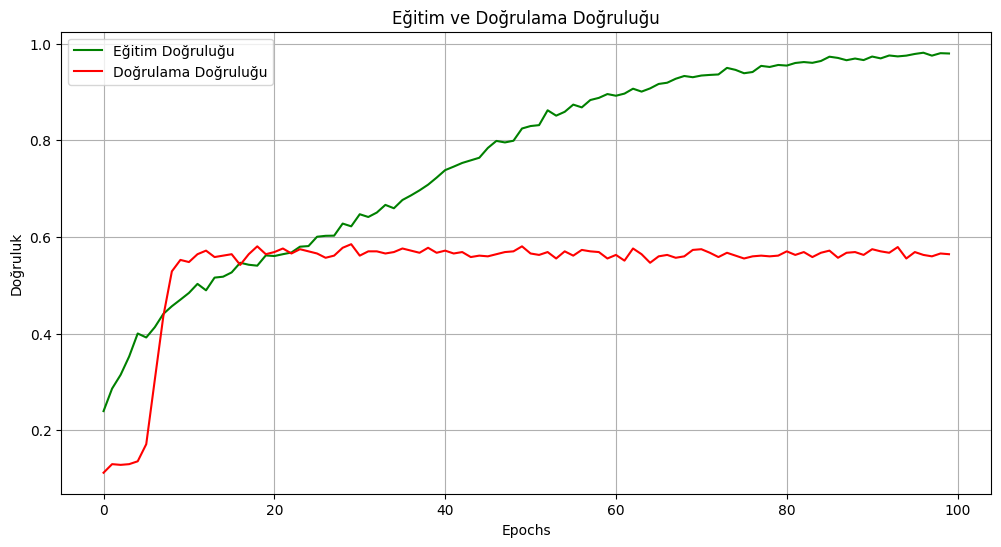

In [12]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kaybını çizdir
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='blue')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='orange')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')
plt.legend()
plt.grid()
plt.show()

# Eğitim ve doğrulama doğruluğunu çizdir
if 'accuracy' in history.history:  # Model doğruluk metriğini içeriyorsa
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='green')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='red')
    plt.title('Eğitim ve Doğrulama Doğruluğu')
    plt.xlabel('Epochs')
    plt.ylabel('Doğruluk')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Doğruluk metrikleri bulunamadı. Lütfen modelinize doğruluk metriği eklediğinizden emin olun.")
